In [1]:
from evaluation_utils import read_global_results, get_best_configuration_per_model
from constants import MODE_1_PROCESSED_DIR, TEST_METRIC, ENCODERS, ENCODER_COLORS, \
                    TRAINING_SCHEMES, TRAINING_SCHEME_COLORS, SSL_MODELS, BASELINES, FONT, SINGLE_ENCODER_MODELS
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import defaultdict
import itertools
from matplotlib.ticker import MultipleLocator

### Data setup

In [2]:
# Read Mode 1 data (raw)
df = read_global_results(MODE_1_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating


In [3]:
best_configurations_all = get_best_configuration_per_model(df, TEST_METRIC, n_best=0)

### Distributions

In [4]:
# Plotting rank of configurations for training_scheme, encoder
param_groups = {20: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(int)))), # group/ts/encoder/param/value/count
                40: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(int)))),
                60: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(int)))),
                80: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(int)))),
                100: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(int))))}

unique_param_values = defaultdict(set)
for ts in TRAINING_SCHEMES:
    for ssl_model in SSL_MODELS:
        for encoder in ENCODERS:
            model = f'{encoder}_{ssl_model}_{ts}'
            if ssl_model in SINGLE_ENCODER_MODELS:
                continue
            if model in best_configurations_all.keys():
                configurations = best_configurations_all[model]
                metric = configurations[f'{model}_{TEST_METRIC}']
                percent_rank = np.arange(0, metric.shape[0]) / metric.shape[0] * 100
                configurations['rank'] = percent_rank

                # Figuring out data for distributions
                for index, row in configurations.iterrows():
                    rank = row['rank']
                    for c in configurations.columns:
                        param = c.removeprefix(f'{model}_')
                        param = param.removeprefix('train_')
                        param = param.removeprefix('encoder_')
                        param = param.replace('_', " ")
                        if param in ['hidden channels', 'num layers', 'dropout', 'downstream lr', 'pretext epochs', 'pretext lr', 'pretext weight', 'heads']:
                            if rank < 20: group = 20
                            elif rank < 40: group = 40
                            elif rank < 60: group = 60
                            elif rank < 80: group = 80
                            else          : group = 100
                            param_value = row[c]
                            if param in ['hidden channels', 'num layers', 'pretext epochs', 'pretext weight', 'heads']:
                                param_value = int(param_value)
                            param_groups[group][ts][encoder][param][param_value] += 1
                            unique_param_values[param].add(param_value)


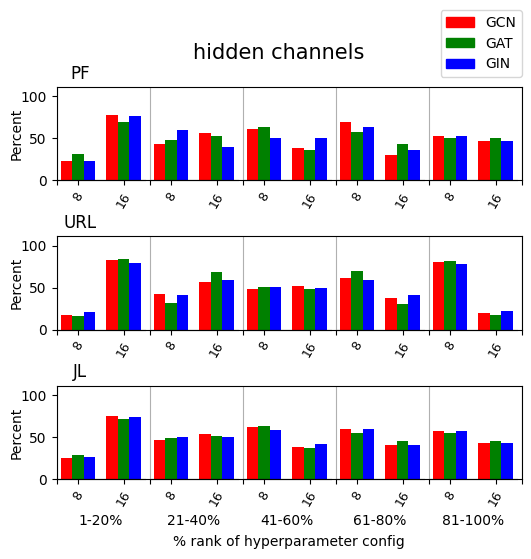

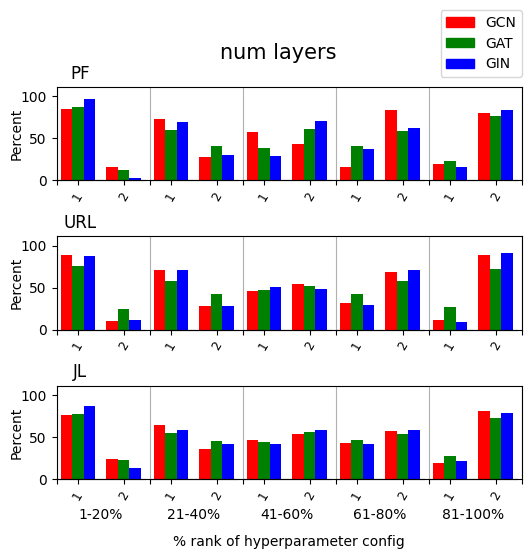

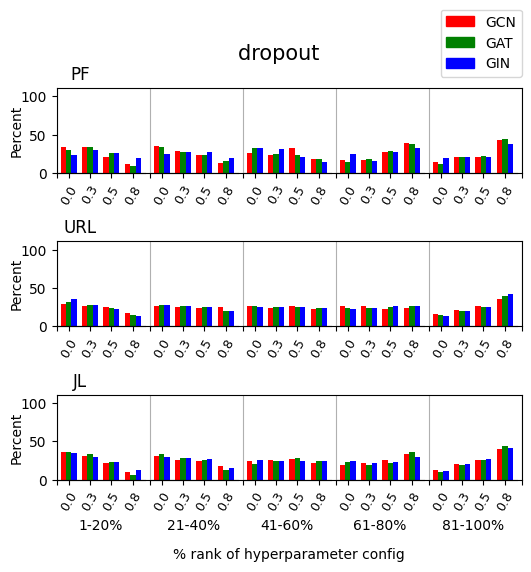

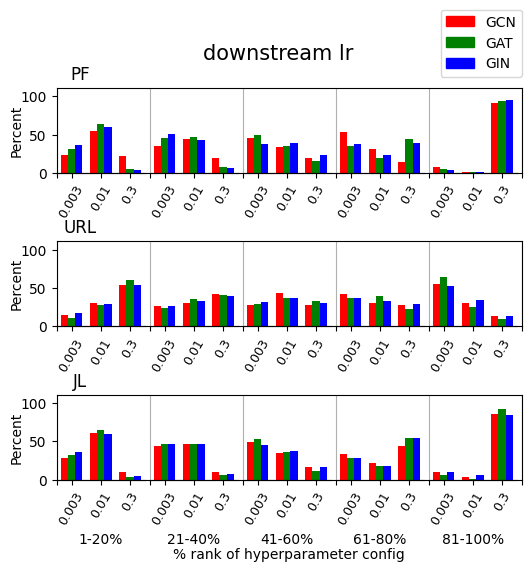

In [118]:

for param in ['hidden channels', 'num layers', 'dropout', 'downstream lr']:
    fig, axes = plt.subplots(3, 1, figsize=(6, 4))
    for i, ts in enumerate(TRAINING_SCHEMES):
        for j, group in enumerate(param_groups.keys()):
            unique_values = sorted(unique_param_values[param])
            ax2 = axes[i].inset_axes((0 + 0.2*j, 0, 0.19, 0.9))
            [ax2.spines[spine].set_visible(False) for spine in ['top', 'right', 'left']]
            width = 0.25
            x_GCN = list(range(len(unique_values)))
            x_GAT = [x + width for x in x_GCN]
            x_GIN = [x + 2*width for x in x_GCN]
            max_GCN = sum([param_groups[group][ts]["GCN"][param][value] for value in unique_values])
            max_GAT = sum([param_groups[group][ts]["GAT"][param][value] for value in unique_values])
            max_GIN = sum([param_groups[group][ts]["GIN"][param][value] for value in unique_values])
            ax2.bar(x_GCN, [param_groups[group][ts]["GCN"][param][value]/max_GCN for value in unique_values], width=width, color=ENCODER_COLORS["GCN"])
            ax2.bar(x_GAT, [param_groups[group][ts]["GAT"][param][value]/max_GAT for value in unique_values], width=width, color=ENCODER_COLORS["GAT"])
            ax2.bar(x_GIN, [param_groups[group][ts]["GIN"][param][value]/max_GIN for value in unique_values], width=width, color=ENCODER_COLORS["GIN"])
            ax2.set_xticks(x_GAT, unique_values, rotation=60, fontsize=9)
            ax2.set_ylim(0, 1)
            ax2.set_zorder(1)
            if i == 2:
                ax2.set_xlabel(f'{group-19}-{group}%')
            if j == 0:
                ax2.set_yticks([0, 0.5, 1])
                ax2.set_yticklabels([0, 50, 100])
            else:
                ax2.set_yticks([])

    
        axes[i].grid(axis='x')
        axes[i].set_xticklabels([])
        axes[i].set_yticks([])
        axes[i].set_ylabel('Percent')
        axes[i].yaxis.set_label_coords(-.07, .5)
        axes[i].set_title(ts,x=.05)

    axes[2].set_xlabel("% rank of hyperparameter config")

    # Create legend
    red_patch = mpl.patches.Patch(color=ENCODER_COLORS["GCN"], label='GCN')
    green_patch = mpl.patches.Patch(color=ENCODER_COLORS["GAT"], label='GAT')
    blue_patch = mpl.patches.Patch(color=ENCODER_COLORS["GIN"], label='GIN')
       
    plt.suptitle(f'{param} ', y=1.1, fontsize=15)
    if param in ['dropout', 'downstream lr']:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8)
        axes[2].xaxis.set_label_coords(.5, -.8)
        plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 5.6), ncol=1)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6)
        axes[2].xaxis.set_label_coords(.5, -.6)
        plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 5.1), ncol=1)
    plt.show()

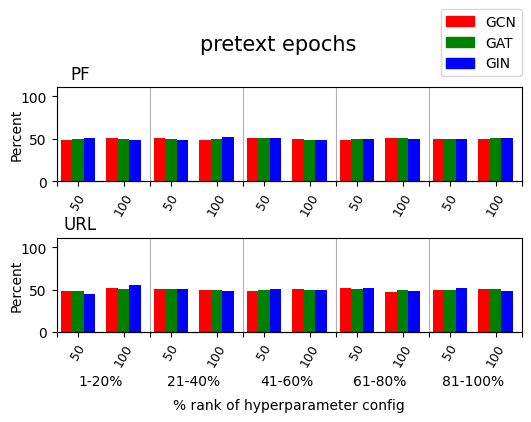

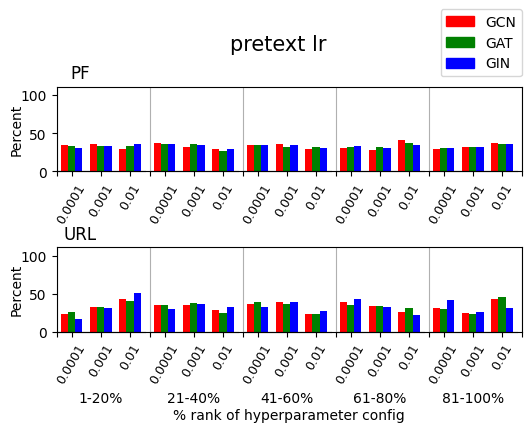

In [153]:

for param in ['pretext epochs', 'pretext lr']:
    fig, axes = plt.subplots(2, 1, figsize=(6, 2.5))
    for i, ts in enumerate(['PF', 'URL']):
        for j, group in enumerate(param_groups.keys()):
            unique_values = sorted(unique_param_values[param])
            ax2 = axes[i].inset_axes((0 + 0.2*j, 0, 0.19, 0.9))
            [ax2.spines[spine].set_visible(False) for spine in ['top', 'right', 'left']]
            width = 0.25
            x_GCN = list(range(len(unique_values)))
            x_GAT = [x + width for x in x_GCN]
            x_GIN = [x + 2*width for x in x_GCN]
            max_GCN = sum([param_groups[group][ts]["GCN"][param][value] for value in unique_values])
            max_GAT = sum([param_groups[group][ts]["GAT"][param][value] for value in unique_values])
            max_GIN = sum([param_groups[group][ts]["GIN"][param][value] for value in unique_values])
            ax2.bar(x_GCN, [param_groups[group][ts]["GCN"][param][value]/max_GCN for value in unique_values], width=width, color=ENCODER_COLORS["GCN"])
            ax2.bar(x_GAT, [param_groups[group][ts]["GAT"][param][value]/max_GAT for value in unique_values], width=width, color=ENCODER_COLORS["GAT"])
            ax2.bar(x_GIN, [param_groups[group][ts]["GIN"][param][value]/max_GIN for value in unique_values], width=width, color=ENCODER_COLORS["GIN"])
            ax2.set_xticks(x_GAT, unique_values, rotation=60, fontsize=9)
            ax2.set_ylim(0, 1)
            ax2.set_zorder(1)
            if i == 1:
                ax2.set_xlabel(f'{group-19}-{group}%')
            if j == 0:
                ax2.set_yticks([0, 0.5, 1])
                ax2.set_yticklabels([0, 50, 100])
            else:
                ax2.set_yticks([])

    
        axes[i].grid(axis='x')
        axes[i].set_xticklabels([])
        axes[i].set_yticks([])
        axes[i].set_ylabel('Percent')
        axes[i].yaxis.set_label_coords(-.07, .5)
        axes[i].set_title(ts,x=.05)

    axes[1].set_xlabel("% rank of hyperparameter config")

    # Create legend
    red_patch = mpl.patches.Patch(color=ENCODER_COLORS["GCN"], label='GCN')
    green_patch = mpl.patches.Patch(color=ENCODER_COLORS["GAT"], label='GAT')
    blue_patch = mpl.patches.Patch(color=ENCODER_COLORS["GIN"], label='GIN')
       
    plt.suptitle(f'{param} ', y=1.2, fontsize=15)
    if param in ['pretext lr']:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.9)
        axes[1].xaxis.set_label_coords(.5, -.9)
        plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 3.9), ncol=1)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6)
        axes[1].xaxis.set_label_coords(.5, -.7)
        plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 3.5), ncol=1)
    plt.show()

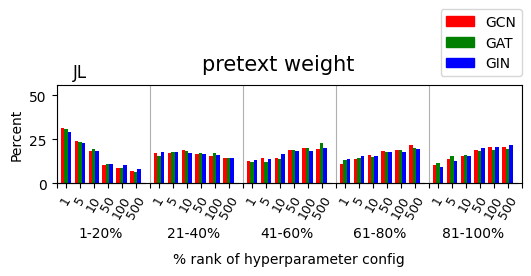

In [138]:

for param in ['pretext weight']:
    fig, axes = plt.subplots(1, 1, figsize=(6, 1))
    for i, ts in enumerate(['JL']):
        for j, group in enumerate(param_groups.keys()):
            unique_values = sorted(unique_param_values[param])
            ax2 = axes.inset_axes((0 + 0.2*j, 0, 0.19, 0.9))
            [ax2.spines[spine].set_visible(False) for spine in ['top', 'right', 'left']]
            width = 0.25
            x_GCN = list(range(len(unique_values)))
            x_GAT = [x + width for x in x_GCN]
            x_GIN = [x + 2*width for x in x_GCN]
            max_GCN = sum([param_groups[group][ts]["GCN"][param][value] for value in unique_values])
            max_GAT = sum([param_groups[group][ts]["GAT"][param][value] for value in unique_values])
            max_GIN = sum([param_groups[group][ts]["GIN"][param][value] for value in unique_values])
            ax2.bar(x_GCN, [param_groups[group][ts]["GCN"][param][value]/max_GCN for value in unique_values], width=width, color=ENCODER_COLORS["GCN"])
            ax2.bar(x_GAT, [param_groups[group][ts]["GAT"][param][value]/max_GAT for value in unique_values], width=width, color=ENCODER_COLORS["GAT"])
            ax2.bar(x_GIN, [param_groups[group][ts]["GIN"][param][value]/max_GIN for value in unique_values], width=width, color=ENCODER_COLORS["GIN"])
            ax2.set_xticks(x_GAT, unique_values, rotation=60, fontsize=9)
            ax2.set_ylim(0, 0.5)
            ax2.set_zorder(1)
            if i == 0:
                ax2.set_xlabel(f'{group-19}-{group}%')
            if j == 0:
                ax2.set_yticks([0, 0.25, 0.5])
                ax2.set_yticklabels([0, 25, 50])
            else:
                ax2.set_yticks([])

    
        axes.grid(axis='x')
        axes.set_xticklabels([])
        axes.set_yticks([])
        axes.set_ylabel('Percent')
        axes.yaxis.set_label_coords(-.07, .5)
        axes.set_title(ts,x=.05)

    axes.set_xlabel("% rank of hyperparameter config")

    # Create legend
    red_patch = mpl.patches.Patch(color=ENCODER_COLORS["GCN"], label='GCN')
    green_patch = mpl.patches.Patch(color=ENCODER_COLORS["GAT"], label='GAT')
    blue_patch = mpl.patches.Patch(color=ENCODER_COLORS["GIN"], label='GIN')
    
    plt.suptitle(f'{param} ', y=1.3, fontsize=15)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6)
    axes.xaxis.set_label_coords(.5, -.7)
    plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 1.85), ncol=1)
    plt.show()

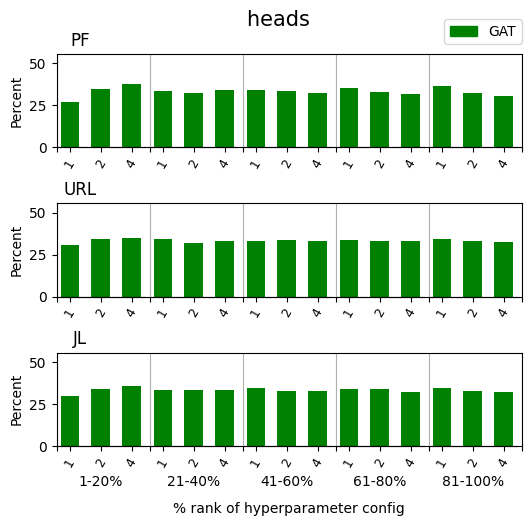

In [148]:

for param in ['heads']:
    fig, axes = plt.subplots(3, 1, figsize=(6, 4))
    for i, ts in enumerate(TRAINING_SCHEMES):
        for j, group in enumerate(param_groups.keys()):
            unique_values = sorted(unique_param_values[param])
            ax2 = axes[i].inset_axes((0 + 0.2*j, 0, 0.19, 0.9))
            [ax2.spines[spine].set_visible(False) for spine in ['top', 'right', 'left']]
            width = 0.6
            x_GAT = list(range(len(unique_values)))
            max_GAT = sum([param_groups[group][ts]["GAT"][param][value] for value in unique_values])
            ax2.bar(x_GAT, [param_groups[group][ts]["GAT"][param][value]/max_GAT for value in unique_values], width=width, color=ENCODER_COLORS["GAT"])
            ax2.set_xticks(x_GAT, unique_values, rotation=60, fontsize=9)
            ax2.set_ylim(0, 0.5)
            ax2.set_zorder(1)
            if i == 2:
                ax2.set_xlabel(f'{group-19}-{group}%')
            if j == 0:
                ax2.set_yticks([0, 0.25, 0.5])
                ax2.set_yticklabels([0, 25, 50])
            else:
                ax2.set_yticks([])

    
        axes[i].grid(axis='x')
        axes[i].set_xticklabels([])
        axes[i].set_yticks([])
        axes[i].set_ylabel('Percent')
        axes[i].yaxis.set_label_coords(-.07, .5)
        axes[i].set_title(ts,x=.05)

    axes[2].set_xlabel("% rank of hyperparameter config")

    # Create legend
    green_patch = mpl.patches.Patch(color=ENCODER_COLORS["GAT"], label='GAT')
       
    plt.suptitle(f'{param} ', y=1.1, fontsize=15)
    if param in ['dropout', 'downstream lr']:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8)
        axes[2].xaxis.set_label_coords(.5, -.8)
        plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.015, 5.6), ncol=1)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6)
        axes[2].xaxis.set_label_coords(.5, -.6)
        plt.legend(handles=[green_patch], loc='upper right', bbox_to_anchor=(1.015, 4.65), ncol=1)
    plt.show()

### Lineplots

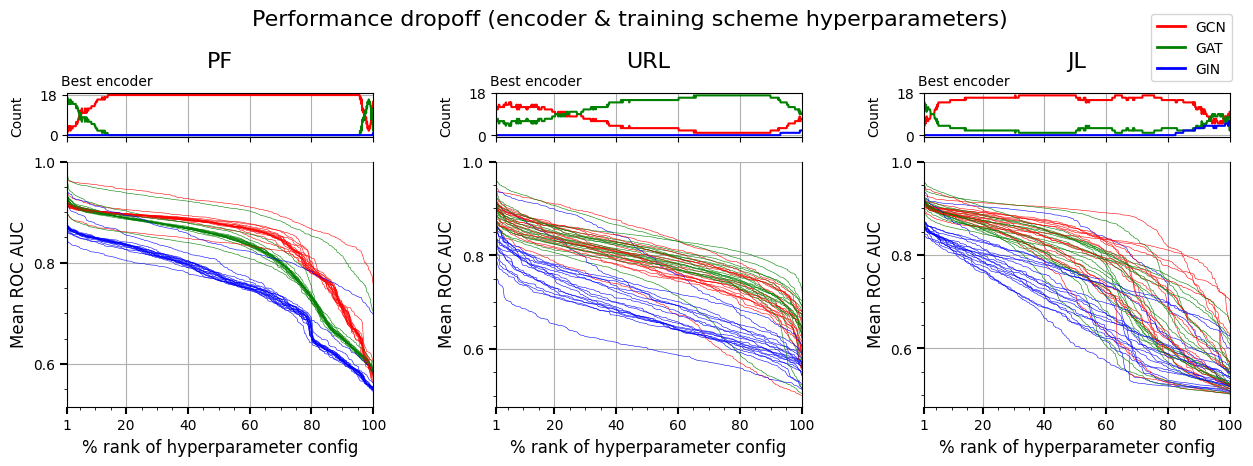

0.13316038151825182 max
0.05404753282362934 mean
0.01572758957725995 min


In [244]:
# Plotting rank of configurations for training_scheme, encoder
plt.rcParams["font.family"] = FONT
fig, axs = plt.subplots(1, 3, figsize=(15, 2.5))

drop_off_20 = []
for axi, (ts, ax) in enumerate(zip(TRAINING_SCHEMES, axs)):
    best_encoders_y = {}                        
    best_encoders_x = np.linspace(0,100, 1000)
    for encoder in ENCODERS:
        best_encoders_y[encoder] = [0] * 1000
    for ssl_model in SSL_MODELS:
        encoder_perf = {}
        for encoder in ENCODERS:
            model = f'{encoder}_{ssl_model}_{ts}'
            if ssl_model in SINGLE_ENCODER_MODELS:
                continue
            if model in best_configurations_all.keys():
                configurations = best_configurations_all[model]
                metric = configurations[f'{model}_{TEST_METRIC}']
                percent_rank = np.arange(0, metric.shape[0]) / metric.shape[0] * 100
                drop_off_20.append(metric[0]-metric[np.where(percent_rank >= 20)[0][0]])
                encoder_perf[encoder] = percent_rank, metric
                ax.plot(percent_rank+1, metric, color=ENCODER_COLORS[encoder], label=encoder, linewidth=0.4)
        # Figuring out data for top plot
        if len(encoder_perf) == len(ENCODERS):
            for idx, x in enumerate(best_encoders_x):
                gcn_perf = encoder_perf["GCN"][1][np.argmin(np.abs(x - encoder_perf["GCN"][0]))]
                gat_perf = encoder_perf["GAT"][1][np.argmin(np.abs(x - encoder_perf["GAT"][0]))]
                gin_perf = encoder_perf["GIN"][1][np.argmin(np.abs(x - encoder_perf["GIN"][0]))]
                if gcn_perf > gat_perf and gcn_perf > gin_perf:
                    best_encoders_y["GCN"][idx] += 1
                elif gat_perf > gcn_perf and gat_perf > gin_perf:
                    best_encoders_y["GAT"][idx] += 1
                elif gin_perf > gcn_perf and gin_perf > gat_perf:
                    best_encoders_y["GIN"][idx] += 1

    # Main plot (bottom)
    ax.set_title(ts, fontsize=16, y=1.35)
    ax.set_xlabel("% rank of hyperparameter config", fontsize=12)
    ax.set_ylabel("Mean ROC AUC", fontsize=12)
    ax.set_xticks([1, 20, 40, 60, 80, 100])
    ax.set_yticks([0.6, 0.8, 1.0])
    ax.set_xlim(1, 100)
    ax.grid()
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='y', direction='out', length=5, width=1.5)
    ax.tick_params(axis='x', direction='out', length=5, width=1.5)
    [ax.spines[spine].set_visible(False) for spine in ['top']]


    # Top plot
    ax2 = ax.inset_axes((0, 1.1, 1, 0.18))
    ax2.plot(best_encoders_x, best_encoders_y["GCN"], color=ENCODER_COLORS["GCN"], label=encoder)
    ax2.plot(best_encoders_x, best_encoders_y["GAT"], color=ENCODER_COLORS["GAT"], label=encoder)
    ax2.plot(best_encoders_x, best_encoders_y["GIN"], color=ENCODER_COLORS["GIN"], label=encoder)
    #[ax2.spines[spine].set_visible(False) for spine in ["top"]]
    ax2.set_xticks([1, 20, 40, 60, 80, 100])
    ax2.set_xticklabels([])
    ax2.grid()
    ax2.set_yticks([0, best_encoders_y["GCN"][0] + best_encoders_y["GAT"][0] + best_encoders_y["GIN"][0]])
    ax2.set_zorder(1)
    ax2.set_xlim(1, 100)
    ax2.set_title("Best encoder", fontsize=10, x=0.13)
    ax2.set_ylabel("Count", fontsize=10)
    ax2.yaxis.set_label_coords(-0.14, 0.5)

# Final plotting details 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.03, 1.63))
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.suptitle("Performance dropoff (encoder & training scheme hyperparameters)",y=1.6, fontsize=16)
plt.subplots_adjust(top = 0.99, bottom=0.01, wspace=0.4)
plt.show()

print(max(drop_off_20), "max")
print(sum(drop_off_20)/len(drop_off_20), "mean")
print(min(drop_off_20), "min")

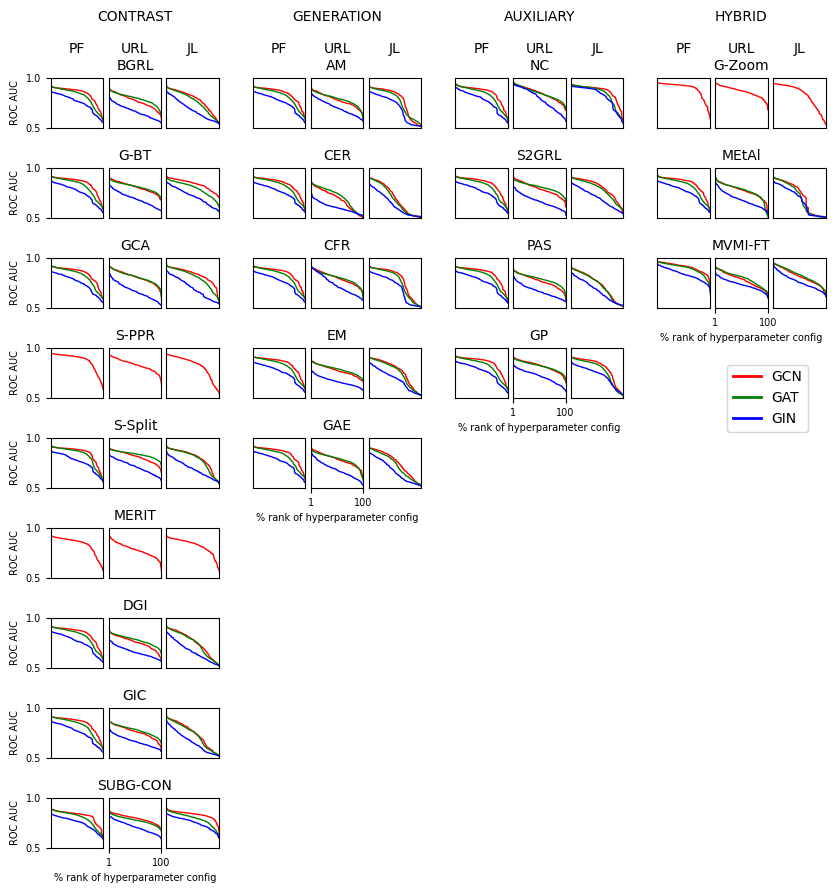

In [111]:
import matplotlib.gridspec as gridspec
from constants import CONTRAST_ALL, GENERATION_ALL, AUXILIARY_ALL, HYBRID_ALL, model_abbreviations

fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(9, 4, wspace=0.2, hspace=0.8)
for i, (ssl_models, title) in enumerate(zip([CONTRAST_ALL, GENERATION_ALL, AUXILIARY_ALL, HYBRID_ALL], ["CONTRAST","GENERATION", "AUXILIARY", "HYBRID"])):
    for j, ssl_model in enumerate(ssl_models):
        inner = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[j, i], wspace=0.1, hspace=0.4)
        for k, ts in enumerate(TRAINING_SCHEMES):
            ax = plt.Subplot(fig, inner[k])
            if k == 1 and j == 0:
                ax.set_title(f"{title}\n\n{ts}\n{model_abbreviations[ssl_model]}", fontsize=10)
            elif k == 1:
                ax.set_title(f"{model_abbreviations[ssl_model]}", fontsize=10)
            elif j == 0:
                ax.set_title(f"{ts}\n", fontsize=10)

            if k == 1 and j == len(ssl_models)-1:
                ax.set_xticks([1, 100])
                ax.set_xticklabels([1, 100], fontsize=7)
                ax.set_xlabel("% rank of hyperparameter config", fontsize=7)
            else:
                ax.set_xticks([])

            if k == 0 and i == 0:
                ax.set_ylabel("ROC AUC", fontsize=7)
                ax.set_yticks([0.5, 1.0])
                ax.set_yticklabels([0.5, 1.0], fontsize=7)
            else:
                ax.set_yticks([])

            ax.set_xlim(1, 100)
            ax.set_ylim(0.5, 1.0)

            fig.add_subplot(ax)

            for encoder in ENCODERS:
                model = f'{encoder}_{ssl_model}_{ts}'
                if model in best_configurations_all.keys():
                    configurations = best_configurations_all[model]
                    metric = configurations[f'{model}_{TEST_METRIC}']
                    percent_rank = np.arange(0, metric.shape[0]) / metric.shape[0] * 100
                    encoder_perf[encoder] = percent_rank, metric
                    ax.plot(percent_rank+1, metric, label=encoder, color=ENCODER_COLORS[encoder], linewidth=1)



# Final plotting details 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.8, -1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.show()
